<a href="https://colab.research.google.com/github/yeesem/Deep_Learning/blob/main/Breast_Cancer_Prediction_Custom_Training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [5]:
!pip install ucimlrepo

In [40]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools
from tqdm import tqdm
import tensorflow_datasets as tfds
from ucimlrepo import fetch_ucirepo

# Load and Preprocess the Dataset

In [27]:
# fetch dataset
breast_cancer_wisconsin_original = fetch_ucirepo(id=15)

# data (as pandas dataframes)
X = breast_cancer_wisconsin_original.data.features
y = breast_cancer_wisconsin_original.data.targets

df = pd.concat([X, y], axis=1)

In [28]:
# X.pop('id')

In [29]:
df = df[df["Bare_nuclei"] != '?' ]
X.bare_nuclei = pd.to_numeric(df.Bare_nuclei)

<ipython-input-29-99bb1d103041>:2: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  X.bare_nuclei = pd.to_numeric(df.Bare_nuclei)


<Axes: >

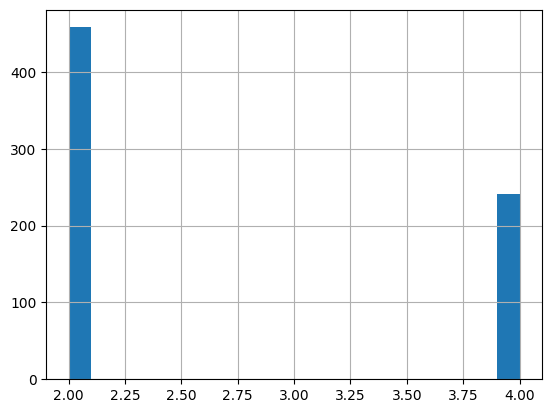

In [30]:
df['Class'].hist(bins=20)

In [31]:
# if == 2, True = 0, False = 1
df['Class'] = np.where(df['Class'] == 2, 0, 1)
df.head()

,Clump_thickness,Uniformity_of_cell_size,Uniformity_of_cell_shape,Marginal_adhesion,Single_epithelial_cell_size,Bare_nuclei,Bland_chromatin,Normal_nucleoli,Mitoses,Class
0,5,1,1,1,2,1.0,3,1,1,0
1,5,4,4,5,7,10.0,3,2,1,0
2,3,1,1,1,2,2.0,3,1,1,0
3,6,8,8,1,3,4.0,3,7,1,0
4,4,1,1,3,2,1.0,3,1,1,0


In [32]:
train, test = train_test_split(df, test_size = 0.2)

In [33]:
train_stats = train.describe()
train_stats.pop('Class')
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
Clump_thickness,559.0,4.382826,2.794668,1.0,2.0,4.0,6.00,10.0
Uniformity_of_cell_size,559.0,3.203936,3.089684,1.0,1.0,1.0,5.00,10.0
Uniformity_of_cell_shape,559.0,3.254025,3.000576,1.0,1.0,1.0,5.00,10.0
Marginal_adhesion,559.0,2.899821,2.910366,1.0,1.0,1.0,4.00,10.0
Single_epithelial_cell_size,559.0,3.284436,2.249562,1.0,2.0,2.0,4.00,10.0
Bare_nuclei,550.0,3.569091,3.620644,1.0,1.0,1.0,6.75,10.0
Bland_chromatin,559.0,3.470483,2.419034,1.0,2.0,3.0,5.00,10.0
Normal_nucleoli,559.0,2.906977,3.065931,1.0,1.0,1.0,4.00,10.0
Mitoses,559.0,1.652952,1.836836,1.0,1.0,1.0,1.00,10.0


In [35]:
train_Y = train.pop("Class")
test_Y = test.pop("Class")

In [36]:
def norm(x):
    return (x - train_stats['mean']) / train_stats['std']

In [38]:
norm_train_X = norm(train)
norm_test_X = norm(test)

In [39]:
norm_train_X.values

array([[-1.21045727, -0.71332063, -0.75119747, ..., -0.1944921 ,
        -0.29582425, -0.35547638],
       [ 0.22083964, -0.71332063, -0.75119747, ..., -0.60788024,
        -0.29582425, -0.35547638],
       [-1.21045727, -0.06600532, -0.75119747, ...,  0.63228419,
         0.03034095,  0.18893813],
       ...,
       [-0.85263304, -0.71332063, -0.75119747, ..., -0.60788024,
        -0.62198944, -0.35547638],
       [-0.49480882,  0.90496766,  0.91514929, ...,  1.04567234,
         1.66116692,  0.73335265],
       [ 0.22083964, -0.06600532, -0.08465876, ..., -0.1944921 ,
         0.03034095,  0.73335265]])

In [41]:
train_dataset = tf.data.Dataset.from_tensor_slices((norm_train_X.values, train_Y.values))
test_dataset = tf.data.Dataset.from_tensor_slices((norm_test_X.values, test_Y.values))

In [42]:
batch_size = 32
train_dataset = train_dataset.shuffle(buffer_size=len(train)).batch(batch_size)

test_dataset =  test_dataset.batch(batch_size=batch_size)

In [43]:
a = enumerate(train_dataset)

print(len(list(a)))

18


# Define the Model

In [45]:
def base_model():
    inputs = tf.keras.layers.Input(shape=(len(train.columns)))

    x = tf.keras.layers.Dense(128, activation='relu')(inputs)
    x = tf.keras.layers.Dense(64, activation='relu')(x)
    outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model

model = base_model()

# Define Optimizer and Loss

In [46]:
optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.001)
loss_object = tf.keras.losses.BinaryCrossentropy()

# Evaluate Untrained Model